**Source of the materials**: Biopython Tutorial and Cookbook (adapted)

# Phylogenetics with Bio.Phylo

## Demo: what is in a tree?

Lets open an example newick file

In [1]:
import copy
from io import StringIO

from Bio import Phylo
from Bio.Phylo.Applications import PhymlCommandline
from Bio.Phylo.PAML import codeml
from Bio.Phylo.PhyloXML import Phylogeny

%matplotlib inline

tree = Phylo.read("data/simple.dnd", "newick")

Printing the tree object as a string gives us a look at the entire object hierarchy.

In [2]:
print(tree)

Tree(rooted=False, weight=1.0)
    Clade()
        Clade()
            Clade()
                Clade(name='A')
                Clade(name='B')
            Clade()
                Clade(name='C')
                Clade(name='D')
        Clade()
            Clade(name='E')
            Clade(name='F')
            Clade(name='G')


The Tree object contains global information about the tree, such as whether it’s rooted or unrooted. It has one root clade, and under that, it’s nested lists of clades all the way down to the tips.

The function draw_ascii creates a simple ASCII-art (plain text) dendrogram. This is a convenient visualization for interactive exploration, in case better graphical tools aren’t available.

In [3]:
Phylo.draw_ascii(tree)

                                                    ________________________ A
                           ________________________|
                          |                        |________________________ B
  ________________________|
 |                        |                         ________________________ C
 |                        |________________________|
_|                                                 |________________________ D
 |
 |                         ________________________ E
 |                        |
 |________________________|________________________ F
                          |
                          |________________________ G



you can create a graphic using the draw function

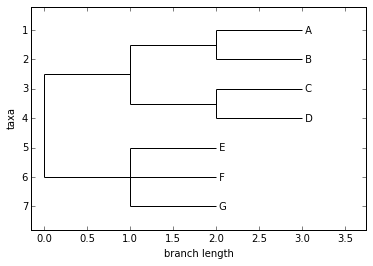

In [4]:
tree.rooted = True
Phylo.draw(tree)

### Coloring branches within a tree

The functions draw and draw_graphviz support the display of different colors and branch widths in a tree. As of Biopython 1.59, the color and width attributes are available on the basic Clade object and there’s nothing extra required to use them. Both attributes refer to the branch leading the given clade, and apply recursively, so all descendent branches will also inherit the assigned width and color values during display.

In earlier versions of Biopython, these were special features of PhyloXML trees, and using the attributes required first converting the tree to a subclass of the basic tree object called Phylogeny, from the Bio.Phylo.PhyloXML module.

In Biopython 1.55 and later, this is a convenient tree method:

In [5]:
tree = tree.as_phyloxml()
tree = Phylogeny.from_tree(tree)

Note that the file formats Newick and Nexus don’t support branch colors or widths, so if you use these attributes in Bio.Phylo, you will only be able to save the values in PhyloXML format. (You can still save a tree as Newick or Nexus, but the color and width values will be skipped in the output file.)

Now we can begin assigning colors. First, we’ll color the root clade gray. We can do that by assigning the 24-bit color value as an RGB triple, an HTML-style hex string, or the name of one of the predefined colors.

In [6]:
tree.root.color = (128, 128, 128)
tree.root.color = "#808080"        # This is one alternative
tree.root.color = "gray"           # This is another

Colors for a clade are treated as cascading down through the entire clade, so when we colorize the root here, it turns the whole tree gray. We can override that by assigning a different color lower down on the tree.

Let’s target the most recent common ancestor (MRCA) of the nodes named “E” and “F”. The common_ancestor method returns a reference to that clade in the original tree, so when we color that clade “salmon”, the color will show up in the original tree.

In [7]:
mrca = tree.common_ancestor({"name": "E"}, {"name": "F"})
mrca.color = "salmon"

If we happened to know exactly where a certain clade is in the tree, in terms of nested list entries, we can jump directly to that position in the tree by indexing it. Here, the index [0,1] refers to the second child of the first child of the root.

In [8]:
tree.clade[0, 1].color = "blue"

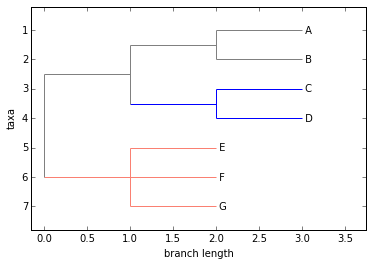

In [9]:
Phylo.draw(tree)

Note that a clade’s color includes the branch leading to that clade, as well as its descendents. The common ancestor of E and F turns out to be just under the root, and with this coloring we can see exactly where the root of the tree is.

My, we’ve accomplished a lot! Let’s take a break here and save our work. Call the write function with a file name or handle — here we use standard output, to see what would be written — and the format phyloxml. PhyloXML saves the colors we assigned, so you can open this phyloXML file in another tree viewer like Archaeopteryx, and the colors will show up there, too.

## I/O functions

Like SeqIO and AlignIO, Phylo handles file input and output through four functions: parse, read, write and convert, all of which support the tree file formats Newick, NEXUS, phyloXML and NeXML, as well as the Comparative Data Analysis Ontology (CDAO).

The read function parses a single tree in the given file and returns it. Careful; it will raise an error if the file contains more than one tree, or no trees.

In [10]:
#from Bio import Phylo
tree = Phylo.read("data/int_node_labels.nwk", "newick")
print(tree)

Tree(rooted=False, weight=1.0)
    Clade(branch_length=75.0, name='gymnosperm')
        Clade(branch_length=25.0, name='Coniferales')
            Clade(branch_length=25.0)
                Clade(branch_length=10.0, name='Tax+nonSci')
                    Clade(branch_length=90.0, name='Taxaceae')
                        Clade(branch_length=125.0, name='Cephalotaxus')
                        Clade(branch_length=25.0, name='TT1')
                            Clade(branch_length=100.0, name='Taxus')
                            Clade(branch_length=100.0, name='Torreya')
                    Clade(branch_length=15.0, name='nonSci')
                        Clade(branch_length=15.11, name='Taw+others')
                            Clade(branch_length=49.060001, name='STCC')
                                Clade(branch_length=5.83, name='CupCallTax')
                                    Clade(branch_length=30.0, name='CJCPTT')
                                        Clade(branch_length=5.0, name='CC

To handle multiple (or an unknown number of) trees, use the parse function iterates through each of the trees in the given file:

In [19]:
trees = Phylo.parse("data/phyloxml_examples.xml", "phyloxml")
trees = list(trees)
for tree in trees:
    print(tree)

Phylogeny(description='phyloXML allows to use either a "branch_length" attribute...', name='example from Prof. Joe Felsenstein's book "Inferring Phyl...', rooted=True)
    Clade()
        Clade(branch_length=0.06)
            Clade(branch_length=0.102, name='A')
            Clade(branch_length=0.23, name='B')
        Clade(branch_length=0.4, name='C')
Phylogeny(description='phyloXML allows to use either a "branch_length" attribute...', name='example from Prof. Joe Felsenstein's book "Inferring Phyl...', rooted=True)
    Clade()
        Clade(branch_length=0.06)
            Clade(branch_length=0.102, name='A')
            Clade(branch_length=0.23, name='B')
        Clade(branch_length=0.4, name='C')
Phylogeny(name='same example, with support of type "bootstrap"', rooted=True)
    Clade()
        Clade(branch_length=0.06, name='AB')
            Clade(branch_length=0.102, name='A')
            Clade(branch_length=0.23, name='B')
            Confidence(type='bootstrap', value=89.0)
       

Write a tree or iterable of trees back to file with the write function:

In [20]:
tree1 = trees[0]
Phylo.write(tree1, "data/tree1.xml", "phyloxml")

TypeError: must be str, not bytes

In [ ]:
others = trees[1:]
Phylo.write(others, "data/other_trees.xml", "phyloxml")

Convert files between any of the supported formats with the convert function:

In [ ]:
Phylo.convert("data/tree1.nwk", "newick", "data/tree1.xml", "nexml")

In [ ]:
Phylo.convert("data/other_trees.xml", "phyloxml", "data/other_trees.nex", "nexus")

To use strings as input or output instead of actual files, use StringIO as you would with SeqIO and AlignIO:

In [ ]:
handle = StringIO("(((A,B),(C,D)),(E,F,G));")
tree = Phylo.read(handle, "newick")

## View and export trees

The simplest way to get an overview of a Tree object is to print it:

In [ ]:
tree = Phylo.read("data/example.xml", "phyloxml")
print(tree)

This is essentially an outline of the object hierarchy Biopython uses to represent a tree. But more likely, you’d want to see a drawing of the tree. There are three functions to do this.

As we saw in the demo, draw_ascii prints an ascii-art drawing of the tree (a rooted phylogram) to standard output, or an open file handle if given. Not all of the available information about the tree is shown, but it provides a way to quickly view the tree without relying on any external dependencies.

In [ ]:
Phylo.draw_ascii(tree)

The draw function draws a more attractive image using the matplotlib library. See the API documentation for details on the arguments it accepts to customize the output.

In [ ]:
Phylo.draw(tree, branch_labels=lambda c: c.branch_length)

draw_graphviz draws an unrooted cladogram, but requires that you have Graphviz, PyDot or PyGraphviz, NetworkX, and matplotlib (or pylab) installed. Using the same example as above, and the dot program included with Graphviz, let’s draw a rooted tree (see Fig. 13.3):



In [ ]:
Phylo.draw_graphviz(tree, prog='dot')

This exports the tree object to a NetworkX graph, uses Graphviz to lay out the nodes, and displays it using matplotlib. There are a number of keyword arguments that can modify the resulting diagram, including most of those accepted by the NetworkX functions networkx.draw and networkx.draw_graphviz.

The display is also affected by the rooted attribute of the given tree object. Rooted trees are shown with a “head” on each branch indicating direction (see Fig. 13.3):

In [ ]:
tree = Phylo.read("data/simple.dnd", "newick")
tree.rooted = True
Phylo.draw_graphviz(tree)

The “prog” argument specifies the Graphviz engine used for layout. The default, twopi, behaves well for any size tree, reliably avoiding crossed branches. The neato program may draw more attractive moderately-sized trees, but sometimes will cross branches (see Fig. 13.3). The dot program may be useful with small trees, but tends to do surprising things with the layout of larger trees.

In [ ]:
Phylo.draw_graphviz(tree, prog="neato")

This viewing mode is particularly handy for exploring larger trees, because the matplotlib viewer can zoom in on a selected region, thinning out a cluttered graphic.

In [ ]:
tree = Phylo.read("data/apaf.xml", "phyloxml")
Phylo.draw_graphviz(tree, prog="neato", node_size=0)

Note that branch lengths are not displayed accurately, because Graphviz ignores them when creating the node layouts. The branch lengths are retained when exporting a tree as a NetworkX graph object (to_networkx), however.

See the Phylo page on the Biopython wiki (http://biopython.org/wiki/Phylo) for descriptions and examples of the more advanced functionality in draw_ascii, draw_graphviz and to_networkx.

## Using Tree and Clade objects

The Tree objects produced by parse and read are containers for recursive sub-trees, attached to the Tree object at the root attribute (whether or not the phylogenic tree is actually considered rooted). A Tree has globally applied information for the phylogeny, such as rootedness, and a reference to a single Clade; a Clade has node- and clade-specific information, such as branch length, and a list of its own descendent Clade instances, attached at the clades attribute.

So there is a distinction between tree and tree.root. In practice, though, you rarely need to worry about it. To smooth over the difference, both Tree and Clade inherit from TreeMixin, which contains the implementations for methods that would be commonly used to search, inspect or modify a tree or any of its clades. This means that almost all of the methods supported by tree are also available on tree.root and any clade below it. (Clade also has a root property, which returns the clade object itself.)

### Search and traversal methods

For convenience, we provide a couple of simplified methods that return all external or internal nodes directly as a list:

get_terminals
makes a list of all of this tree’s terminal (leaf) nodes.
get_nonterminals
makes a list of all of this tree’s nonterminal (internal) nodes.
These both wrap a method with full control over tree traversal, find_clades. Two more traversal methods, find_elements and find_any, rely on the same core functionality and accept the same arguments, which we’ll call a “target specification” for lack of a better description. These specify which objects in the tree will be matched and returned during iteration. The first argument can be any of the following types:

A TreeElement instance, which tree elements will match by identity — so searching with a Clade instance as the target will find that clade in the tree;
A string, which matches tree elements’ string representation — in particular, a clade’s name (added in Biopython 1.56);
A class or type, where every tree element of the same type (or sub-type) will be matched;
A dictionary where keys are tree element attributes and values are matched to the corresponding attribute of each tree element. This one gets even more elaborate:
If an int is given, it matches numerically equal attributes, e.g. 1 will match 1 or 1.0
If a boolean is given (True or False), the corresponding attribute value is evaluated as a boolean and checked for the same
None matches None
If a string is given, the value is treated as a regular expression (which must match the whole string in the corresponding element attribute, not just a prefix). A given string without special regex characters will match string attributes exactly, so if you don’t use regexes, don’t worry about it. For example, in a tree with clade names Foo1, Foo2 and Foo3, tree.find_clades({"name": "Foo1"}) matches Foo1, {"name": "Foo.*"} matches all three clades, and {"name": "Foo"} doesn’t match anything.
Since floating-point arithmetic can produce some strange behavior, we don’t support matching floats directly. Instead, use the boolean True to match every element with a nonzero value in the specified attribute, then filter on that attribute manually with an inequality (or exact number, if you like living dangerously).

If the dictionary contains multiple entries, a matching element must match each of the given attribute values — think “and”, not “or”.

A function taking a single argument (it will be applied to each element in the tree), returning True or False. For convenience, LookupError, AttributeError and ValueError are silenced, so this provides another safe way to search for floating-point values in the tree, or some more complex characteristic.
After the target, there are two optional keyword arguments:

terminal
— A boolean value to select for or against terminal clades (a.k.a. leaf nodes): True searches for only terminal clades, False for non-terminal (internal) clades, and the default, None, searches both terminal and non-terminal clades, as well as any tree elements lacking the is_terminal method.
order
— Tree traversal order: "preorder" (default) is depth-first search, "postorder" is DFS with child nodes preceding parents, and "level" is breadth-first search.
Finally, the methods accept arbitrary keyword arguments which are treated the same way as a dictionary target specification: keys indicate the name of the element attribute to search for, and the argument value (string, integer, None or boolean) is compared to the value of each attribute found. If no keyword arguments are given, then any TreeElement types are matched. The code for this is generally shorter than passing a dictionary as the target specification: tree.find_clades({"name": "Foo1"}) can be shortened to tree.find_clades(name="Foo1").

(In Biopython 1.56 or later, this can be even shorter: tree.find_clades("Foo1"))

Now that we’ve mastered target specifications, here are the methods used to traverse a tree:

find_clades
Find each clade containing a matching element. That is, find each element as with find_elements, but return the corresponding clade object. (This is usually what you want.)
The result is an iterable through all matching objects, searching depth-first by default. This is not necessarily the same order as the elements appear in the Newick, Nexus or XML source file!

find_elements
Find all tree elements matching the given attributes, and return the matching elements themselves. Simple Newick trees don’t have complex sub-elements, so this behaves the same as find_clades on them. PhyloXML trees often do have complex objects attached to clades, so this method is useful for extracting those.
find_any
Return the first element found by find_elements(), or None. This is also useful for checking whether any matching element exists in the tree, and can be used in a conditional.
Two more methods help navigating between nodes in the tree:

get_path
List the clades directly between the tree root (or current clade) and the given target. Returns a list of all clade objects along this path, ending with the given target, but excluding the root clade.
trace
List of all clade object between two targets in this tree. Excluding start, including finish.

### Information methods

These methods provide information about the whole tree (or any clade).

common_ancestor
Find the most recent common ancestor of all the given targets. (This will be a Clade object). If no target is given, returns the root of the current clade (the one this method is called from); if 1 target is given, this returns the target itself. However, if any of the specified targets are not found in the current tree (or clade), an exception is raised.
count_terminals
Counts the number of terminal (leaf) nodes within the tree.
depths
Create a mapping of tree clades to depths. The result is a dictionary where the keys are all of the Clade instances in the tree, and the values are the distance from the root to each clade (including terminals). By default the distance is the cumulative branch length leading to the clade, but with the unit_branch_lengths=True option, only the number of branches (levels in the tree) is counted.
distance
Calculate the sum of the branch lengths between two targets. If only one target is specified, the other is the root of this tree.
total_branch_length
Calculate the sum of all the branch lengths in this tree. This is usually just called the “length” of the tree in phylogenetics, but we use a more explicit name to avoid confusion with Python terminology.
The rest of these methods are boolean checks:

is_bifurcating
True if the tree is strictly bifurcating; i.e. all nodes have either 2 or 0 children (internal or external, respectively). The root may have 3 descendents and still be considered part of a bifurcating tree.
is_monophyletic
Test if all of the given targets comprise a complete subclade — i.e., there exists a clade such that its terminals are the same set as the given targets. The targets should be terminals of the tree. For convenience, this method returns the common ancestor (MCRA) of the targets if they are monophyletic (instead of the value True), and False otherwise.
is_parent_of
True if target is a descendent of this tree — not required to be a direct descendent. To check direct descendents of a clade, simply use list membership testing: if subclade in clade: ...
is_preterminal
True if all direct descendents are terminal; False if any direct descendent is not terminal.

### Modification methods

These methods modify the tree in-place. If you want to keep the original tree intact, make a complete copy of the tree first, using Python’s copy module:

In [ ]:
tree = Phylo.read('data/example.xml', 'phyloxml')
newtree = copy.deepcopy(tree)

collapse
Deletes the target from the tree, relinking its children to its parent.
collapse_all
Collapse all the descendents of this tree, leaving only terminals. Branch lengths are preserved, i.e. the distance to each terminal stays the same. With a target specification (see above), collapses only the internal nodes matching the specification.
ladderize
Sort clades in-place according to the number of terminal nodes. Deepest clades are placed last by default. Use reverse=True to sort clades deepest-to-shallowest.
prune
Prunes a terminal clade from the tree. If taxon is from a bifurcation, the connecting node will be collapsed and its branch length added to remaining terminal node. This might no longer be a meaningful value.
root_with_outgroup
Reroot this tree with the outgroup clade containing the given targets, i.e. the common ancestor of the outgroup. This method is only available on Tree objects, not Clades.
If the outgroup is identical to self.root, no change occurs. If the outgroup clade is terminal (e.g. a single terminal node is given as the outgroup), a new bifurcating root clade is created with a 0-length branch to the given outgroup. Otherwise, the internal node at the base of the outgroup becomes a trifurcating root for the whole tree. If the original root was bifurcating, it is dropped from the tree.

In all cases, the total branch length of the tree stays the same.

root_at_midpoint
Reroot this tree at the calculated midpoint between the two most distant tips of the tree. (This uses root_with_outgroup under the hood.)
split
Generate n (default 2) new descendants. In a species tree, this is a speciation event. New clades have the given branch_length and the same name as this clade’s root plus an integer suffix (counting from 0) — for example, splitting a clade named “A” produces the sub-clades “A0” and “A1”.
See the Phylo page on the Biopython wiki (http://biopython.org/wiki/Phylo) for more examples of using the available methods.

### Features of PhyloXML trees

The phyloXML file format includes fields for annotating trees with additional data types and visual cues.

See the PhyloXML page on the Biopython wiki (http://biopython.org/wiki/PhyloXML) for descriptions and examples of using the additional annotation features provided by PhyloXML.

## Running external applications

While Bio.Phylo doesn’t infer trees from alignments itself, there are third-party programs available that do. These are supported through the module Bio.Phylo.Applications, using the same general framework as Bio.Emboss.Applications, Bio.Align.Applications and others.

Biopython 1.58 introduced a wrapper for PhyML (http://www.atgc-montpellier.fr/phyml/). The program accepts an input alignment in phylip-relaxed format (that’s Phylip format, but without the 10-character limit on taxon names) and a variety of options. A quick example:

In [ ]:
#cmd = PhymlCommandline(input='Tests/Phylip/random.phy')
cmd = PhymlCommandline(input='data/random.phy')
out_log, err_log = cmd()

This generates a tree file and a stats file with the names [input filename]_phyml_tree.txt and [input filename]_phyml_stats.txt. The tree file is in Newick format:

In [ ]:
tree = Phylo.read('data/random.phy_phyml_tree.txt', 'newick')
Phylo.draw_ascii(tree)

A similar wrapper for RAxML (http://sco.h-its.org/exelixis/software.html) was added in Biopython 1.60, and FastTree (http://www.microbesonline.org/fasttree/) in Biopython 1.62.

Note that some popular Phylip programs, including dnaml and protml, are already available through the EMBOSS wrappers in Bio.Emboss.Applications if you have the Phylip extensions to EMBOSS installed on your system. See Section 6.4 for some examples and clues on how to use programs like these.

## PAML integration

iopython 1.58 brought support for PAML (http://abacus.gene.ucl.ac.uk/software/paml.html), a suite of programs for phylogenetic analysis by maximum likelihood. Currently the programs codeml, baseml and yn00 are implemented. Due to PAML’s usage of control files rather than command line arguments to control runtime options, usage of this wrapper strays from the format of other application wrappers in Biopython.

A typical workflow would be to initialize a PAML object, specifying an alignment file, a tree file, an output file and a working directory. Next, runtime options are set via the set_options() method or by reading an existing control file. Finally, the program is run via the run() method and the output file is automatically parsed to a results dictionary.

Here is an example of typical usage of codeml:

In [ ]:
cml = codeml.Codeml()
cml.alignment = "data/alignment.phylip"
cml.tree = "data/species.tree"
cml.out_file = "data/results.out"
cml.working_dir = "./"
cml.set_options(seqtype=1,
        verbose=0,
        noisy=0,
        RateAncestor=0,
        model=0,
        NSsites=[0, 1, 2],
        CodonFreq=2,
        cleandata=1,
        fix_alpha=1,
        kappa=4.54006)
results = cml.run()
ns_sites = results.get("NSsites")
m0 = ns_sites.get(0)
m0_params = m0.get("parameters")
print(m0_params.get("omega"))

Existing output files may be parsed as well using a module’s read() function:

In [ ]:
results = codeml.read("data/results.out")
print(results.get("codon model"))

Detailed documentation for this new module currently lives on the Biopython wiki: http://biopython.org/wiki/PAML